In [468]:
import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget
import os, glob


from matplotlib import pyplot
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot


from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
 
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [469]:
# Set column dtypes for Pandas
from datetime import datetime
dt = datetime.utcnow()
COLUMN_NAMES = collections.OrderedDict({
  'Gmt time': object,
  'Open': np.float64,
  'High': np.float64,
  'Low': np.float64,
  'Close': np.float64,
  'Volume': np.float64,
  'Open_Bid': np.float64,
  'High_Bid': np.float64,
  'Low_Bid': np.float64,
  'Close_Bid': np.float64,
  'Volume_Bid': np.float64,
  'Spread': np.float64,
  'day_name': object,
  'weekday': 'category',#'category'np.int64
  'Pct_Range_Close': np.float64,
  'Pct_Range_Close_diff': np.float64,
  'MA_Close_5': np.float64,
  'MA_Close_25': np.float64,
  'MA_Close_50': np.float64,
  'MA_Close_200': np.float64,
  'EMA_Close_5': np.float64,
  'Momentum_1': np.float64,
  'Momentum_2': np.float64,
  'Momentum_5': np.float64,
  'Momentum_24': np.float64,
  'rsi': np.float64,
  'Rolling_Mean25': np.float64,
  'Bollinger_High': np.float64,
  'Bollinger_Low': np.float64,
  'PP': np.float64,
  'R1': np.float64,
  'S1': np.float64,
  'R2': np.float64,
  'S2': np.float64,
  'R3': np.float64,
  'S3': np.float64,
  'SO%k': np.float64,
  'SO%k1': np.float64,
  'SO%d2': np.float64,
  'Trix_5': np.float64,
  'MACD_5_25': np.float64,
  'MACDsign_5_25': np.float64,
  'MACDdiff_5_25': np.float64,
  'Mass_Index_25_8_9': np.float64,
  'Class': np.float64
})

In [470]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ',os.path.basename(file))

0   3C-EURUSD_FULL_1D_145F.csv
1   3C-EURUSD_FULL_1D_21F.csv
2   3C-EURUSD_FULL_1D_45F.csv
3   3C-EURUSD_FULL_1D_70F.csv
4   3C-EURUSD_FULL_1H_45F.csv
5   5C-EURUSD_FULL_1D_21F.csv
6   5C-EURUSD_FULL_1D_27F.csv
7   5C-EURUSD_FULL_1D_45F.csv
8   5C-EURUSD_FULL_1D_70F.csv
9   C-EURUSD_FULL_1D_21F.csv
10   C-EURUSD_FULL_1H_25F.csv
11   C-EURUSD_FULL_1H_45F.csv
12   C-EURUSD_FULL_1H_54F.csv


In [471]:
#SELECT an INDEX 
INDX = 3

CLASS_NUMBER = '3C'
MODEL_TYPE = 'XGBOOST'
FRECUENCIA = '1D'
TARGET_NAME = "Class"
ID = '01'

PROFUNDIDAD = 6

TEST_SIZE = .2
VAL_SIZE = .2

In [472]:
# Load data into Pandas
data = pd.read_csv(filenames[INDX], 
  index_col=False,
  dtype=COLUMN_NAMES
)
data = data.dropna()

#data = shuffle(data, random_state=2)
data.head()

,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,Trix_5,Trix_15,Trix_25,Trix_50,Trix_75,MACD_5_25,MACDsign_5_25,MACDdiff_5_25,Mass_Index_25_8_9,Class
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,0.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,1.0
2,2004-01-04,1.25925,1.26487,1.25789,1.26318,6.879980e+04,1.25855,1.26477,1.25779,1.26308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,1.0
3,2004-01-05,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.26308,1.26924,1.26288,1.26820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,0.0
4,2004-01-06,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.26820,1.28083,1.26650,1.27140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,-1.0


In [473]:
data.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Bid',
       'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 'Spread', 'day_name',
       'weekday', 'Pct_Range_Close', 'Pct_Range_Close_diff', 'AQV',
       'AQM_Pct_Range_Close_diff', 'AQM_Pct_Range_Close', 'MA_Close_5',
       'MA_Close_25', 'MA_Close_50', 'MA_Close_100', 'MA_Close_150',
       'MA_Close_175', 'MA_Close_200', 'EMA_Close_5', 'Momentum_1',
       'Momentum_2', 'Momentum_3', 'Momentum_4', 'Momentum_5', 'Momentum_6',
       'Momentum_7', 'Momentum_8', 'Momentum_9', 'Momentum_10', 'Momentum_11',
       'Momentum_12', 'Momentum_13', 'Momentum_14', 'Momentum_15',
       'Momentum_25', 'Momentum_36', 'Momentum_50', 'Momentum_75',
       'Momentum_80', 'Momentum_100', 'rsi_5', 'rsi_14', 'rsi_25', 'rsi_50',
       'rsi_70', 'Rolling_Mean25', 'Bollinger_High', 'Bollinger_Low', 'SO_k',
       'SO%k1', 'SO%d2', 'Trix_2', 'Trix_5', 'Trix_15', 'Trix_25', 'Trix_50',
       'Trix_75', 'MACD_5_25', 'MACDsign_5_25', 

In [474]:
data = data.drop(['Gmt time'], axis = 1)
data = data.drop(['day_name'], axis = 1)
data = data.drop(['weekday'], axis = 1)
data = data.drop(['Open_Bid'], axis = 1)
data = data.drop(['High_Bid'], axis = 1)
data = data.drop(['Low_Bid'], axis = 1)
data = data.drop(['Close_Bid'], axis = 1)



data = data.drop(['EMA_Close_5'], axis = 1)

data.head()

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_5,Trix_15,Trix_25,Trix_50,Trix_75,MACD_5_25,MACDsign_5_25,MACDdiff_5_25,Mass_Index_25_8_9,Class
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,0.0
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,1.0
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,1.0
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,0.0
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803,-1.0


In [475]:
SIZE = data.shape[0]
NUM_FEATURES = data.shape[1]
print(SIZE)
print(NUM_FEATURES)

5137
62


In [476]:
#LOCATION TO SAVE
pwd = os.getcwd()
source_data_toSave = os.path.join(pwd, r'../../../Models/2020/XGBoost/')
#print('Location to Save: ', source_data)
FILENAME = CLASS_NUMBER + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + str(SIZE) + 'Size_' + MODEL_TYPE +  '_' + TARGET_NAME + "_"+ ID 
file_name_toSave = FILENAME + '.bst'
print('FILENAME: ', FILENAME)
print('File Name Model:', file_name_toSave)

FILENAME:  3C_1D_62F_5137Size_XGBOOST_Class_01
File Name Model: 3C_1D_62F_5137Size_XGBOOST_Class_01.bst


In [477]:
train_dataset_results_csv = os.path.join(pwd, r'../../../Results/XGBoost/' + FILENAME + '_Train.csv')
print(train_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_62F_5137Size_XGBOOST_Class_01_Train.csv


In [478]:
test_dataset_results_csv = os.path.join(pwd, r'../../../Results/XGBoost/' + FILENAME + '_Test.csv')
print(test_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_62F_5137Size_XGBOOST_Class_01_Test.csv


In [479]:
rtest_dataset_results_csv = os.path.join(pwd, r'../../../Results/XGBoost/' + FILENAME + '_RealTest.csv')
print(rtest_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_62F_5137Size_XGBOOST_Class_01_RealTest.csv


In [480]:
# Label preprocessing
labels = data['Class'].values

# See the distribution of approved / denied classes (0: denied, 1: approved)
print(data['Class'].value_counts())

 0.0    2698
 1.0    1221
-1.0    1218
Name: Class, dtype: int64


In [481]:
data = data.drop(columns=['Class'])

In [482]:
def get_2Dimension(df, RANGE):
    new_df = pd.DataFrame()
    for i in range(RANGE):
#        new_df = df
        for j in range (df.shape[1]):
            #value = df.iloc[i+1,j]
            #print(value)
            new_col_name = df.columns[j] + '_' + str(i+1)
            #print(new_col_name)
            new_df[new_col_name] = df.iloc[i+1:,j]
            #print(new_df[new_col_name].isnull().sum())
            new_df.fillna(method='backfill', inplace=True)
            #print(new_df[new_col_name].isnull().sum())
    print(new_df.columns)
    return new_df

 


In [483]:
data

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_2,Trix_5,Trix_15,Trix_25,Trix_50,Trix_75,MACD_5_25,MACDsign_5_25,MACDdiff_5_25,Mass_Index_25_8_9
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.730803
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,0.000332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.730803
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,0.001495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.730803
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,0.002496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.730803
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,0.002732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.730803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132,1.09019,1.09960,1.08970,1.09787,2.219154e+05,2.075363e+05,0.00003,0.007045,0.007631,2.134402e+09,...,0.001542,0.000717,0.000059,-0.000155,-0.000177,-0.000128,0.004185,0.002241,0.001944,24.482205
5133,1.09788,1.10311,1.09342,1.10169,3.392159e+05,3.194905e+05,0.00003,0.003479,-0.003565,2.134742e+09,...,0.002813,0.000947,0.000110,-0.000133,-0.000174,-0.000128,0.006008,0.002994,0.003014,24.641012
5134,1.10168,1.10937,1.09919,1.10782,2.907155e+05,2.312052e+05,0.00003,0.005564,0.002085,2.135032e+09,...,0.003920,0.001341,0.000176,-0.000106,-0.000170,-0.000128,0.008548,0.004105,0.004443,24.865736
5135,1.10780,1.11452,1.10702,1.11071,3.306924e+05,3.730174e+05,0.00035,0.002609,-0.002955,2.135363e+09,...,0.003808,0.001728,0.000255,-0.000075,-0.000166,-0.000127,0.010633,0.005411,0.005222,24.866568


In [484]:
pd_old_rows = get_2Dimension(data,PROFUNDIDAD)

Index(['Open_1', 'High_1', 'Low_1', 'Close_1', 'Volume_1', 'Volume_Bid_1',
       'Spread_1', 'Pct_Range_Close_1', 'Pct_Range_Close_diff_1', 'AQV_1',
       ...
       'Trix_2_5', 'Trix_5_5', 'Trix_15_5', 'Trix_25_5', 'Trix_50_5',
       'Trix_75_5', 'MACD_5_25_5', 'MACDsign_5_25_5', 'MACDdiff_5_25_5',
       'Mass_Index_25_8_9_5'],
      dtype='object', length=305)


In [485]:
pd_old_rows.shape

(5136, 305)

In [486]:
data = pd.concat([data, pd_old_rows], axis=1, sort=False)
data.fillna(method='backfill', inplace=True)
data.shape

(5137, 366)

In [487]:
data.head(30)

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_2_5,Trix_5_5,Trix_15_5,Trix_25_5,Trix_50_5,Trix_75_5,MACD_5_25_5,MACDsign_5_25_5,MACDdiff_5_25_5,Mass_Index_25_8_9_5
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,0.000132,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,0.000132,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,0.000132,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,0.000132,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,0.000132,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
5,1.27161,1.27417,1.26180,1.26377,1.111343e+06,1.345833e+06,0.00010,-0.006079,-0.008602,4.954033e+06,...,0.000132,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
6,1.26369,1.27854,1.25590,1.27696,1.115933e+06,1.348588e+06,0.00010,0.010437,0.016516,6.069966e+06,...,0.002416,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
7,1.27698,1.28676,1.27034,1.28149,1.066698e+06,1.274568e+06,0.00026,0.003547,-0.006890,7.136664e+06,...,0.003520,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
8,1.28279,1.28572,1.28253,1.28477,7.567420e+04,8.780950e+04,0.00010,0.002560,-0.000988,7.212338e+06,...,0.003474,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803
9,1.28498,1.28971,1.27327,1.27390,1.110720e+06,1.341147e+06,0.00010,-0.008461,-0.011020,8.323059e+06,...,-0.000134,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,24.730803


In [488]:
# Convert categorical columns to dummy columns
dummy_columns = list(data.dtypes[data.dtypes == 'category'].index)
data = pd.get_dummies(data, columns=dummy_columns)

In [489]:
# Preview the data
data.head()

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_2_5,Trix_5_5,Trix_15_5,Trix_25_5,Trix_50_5,Trix_75_5,MACD_5_25_5,MACDsign_5_25_5,MACDdiff_5_25_5,Mass_Index_25_8_9_5
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,0.000132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,0.000132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,0.000132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,0.000132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,0.000132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.730803


In [490]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Bid', 'Spread',
       'Pct_Range_Close', 'Pct_Range_Close_diff', 'AQV',
       ...
       'Trix_2_5', 'Trix_5_5', 'Trix_15_5', 'Trix_25_5', 'Trix_50_5',
       'Trix_75_5', 'MACD_5_25_5', 'MACDsign_5_25_5', 'MACDdiff_5_25_5',
       'Mass_Index_25_8_9_5'],
      dtype='object', length=366)

### SPLIT in 3 Sub Datasets

In [491]:

total = data.shape[0]
print('Total: ', total)

s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)

end_val = end_train + count_val
print('end_val', end_val)


Total:  5137
Sum of %s: 0.4
count of Val and Test: 2054
end of train:  3083
count val:  1027
count test:  1027
end_val 4110


In [492]:
data_training = data.iloc[:end_train]
data_val = data.iloc[end_train: end_val]
data_test = data.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = labels[:end_train]
data_val_y = labels[end_train: end_val]
data_test_y = labels[end_val:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (3083, 366)
data_val.shape:  (1027, 366)
data_test.shape:  (1027, 366)
data_training_y.shape:  (3083,)
data_val_y.shape:  (1027,)
data_test_y.shape:  (1027,)


In [493]:
x_train = data_training
x_test = data_val
y_train = data_training_y
y_test = data_val_y

x_rtest = data_test
y_rtest = data_test_y

In [494]:
# Split the data into train / test sets
#x,y = data,labels
#x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42, shuffle=False)

In [495]:
print(x_train.shape)
print(x_train)

(3083, 366)
         Open     High      Low    Close        Volume    Volume_Bid   Spread  \
0     1.25950  1.26052  1.24698  1.25733  4.621817e+05  5.597896e+05  0.00010   
1     1.25717  1.26282  1.25214  1.25832  1.066578e+06  1.277971e+06  0.00026   
2     1.25925  1.26487  1.25789  1.26318  6.879980e+04  8.372040e+04  0.00010   
3     1.26324  1.26935  1.26301  1.26830  1.119689e+06  1.353480e+06  0.00010   
4     1.26836  1.28093  1.26666  1.27150  1.125442e+06  1.354807e+06  0.00010   
...       ...      ...      ...      ...           ...           ...      ...   
3078  1.37237  1.37389  1.35757  1.35792  2.895702e+05  2.710845e+05  0.00002   
3079  1.35791  1.35818  1.34802  1.34883  2.513459e+05  2.257901e+05  0.00035   
3080  1.34870  1.34973  1.34870  1.34924  3.052410e+03  3.347650e+03  0.00003   
3081  1.34922  1.35250  1.34427  1.35156  1.657690e+05  1.679159e+05  0.00003   
3082  1.35155  1.35226  1.34493  1.34721  2.309081e+05  2.189670e+05  0.00002   

      Pct_Range

In [496]:
print(x_test.shape)
x_test.reset_index(drop=True, inplace=True)
print(x_test)

print(x_rtest.shape)
x_rtest.reset_index(drop=True, inplace=True)
print(x_rtest)

(1027, 366)
         Open     High      Low    Close       Volume   Volume_Bid   Spread  \
0     1.34722  1.35480  1.34679  1.35178  192986.0000  187872.7813  0.00003   
1     1.35175  1.35295  1.32956  1.34090  297183.3125  286899.2813  0.00003   
2     1.34089  1.34379  1.33179  1.33706  232163.4844  224716.4531  0.00058   
3     1.33577  1.33625  1.33450  1.33466    4142.5801    4146.3799  0.00002   
4     1.33468  1.34167  1.33468  1.34077  153372.9375  150607.0938  0.00002   
...       ...      ...      ...      ...          ...          ...      ...   
1022  1.06292  1.06382  1.06178  1.06191    5538.0098    5510.5098  0.00004   
1023  1.06189  1.06586  1.05922  1.05991  205467.4375  198618.6719  0.00004   
1024  1.05990  1.06335  1.05610  1.05785  220620.4375  220040.6406  0.00003   
1025  1.05785  1.06094  1.05216  1.06034  237565.8438  239541.8438  0.00004   
1026  1.06034  1.06795  1.06001  1.06714  244667.6875  245245.1094  0.00002   

      Pct_Range_Close  Pct_Range_Close_

In [497]:
print(y_test.shape)
print(y_test)

(1027,)
[-1.  0.  0. ...  0.  1. -1.]


In [498]:
# Train the model, this will take a few minutes to run
bst = xgb.XGBClassifier(
    objective='reg:logistic'
)

bst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [499]:
# Save the model so we can deploy it
#bst.save_model(source_data_toSave + file_name_toSave)

In [500]:
#bst_loaded = xgb.Booster({'nthread': 4})  # init model
#bst_loaded.load_model(source_data_toSave + file_name_toSave)  # load data

In [501]:
# Get predictions on the test set and print the accuracy score
y_pred = bst.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print(acc, '\n')

0.46932814021421615 



In [502]:
# Print a confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred.round())
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)

Confusion matrix:
[[0.064      0.23867596 0.47783251]
 [0.124      0.65853659 0.81280788]
 [0.028      0.18815331 0.43349754]]


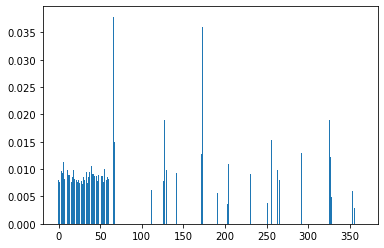

In [503]:

#print(bst.feature_importances_)
pyplot.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
pyplot.show()

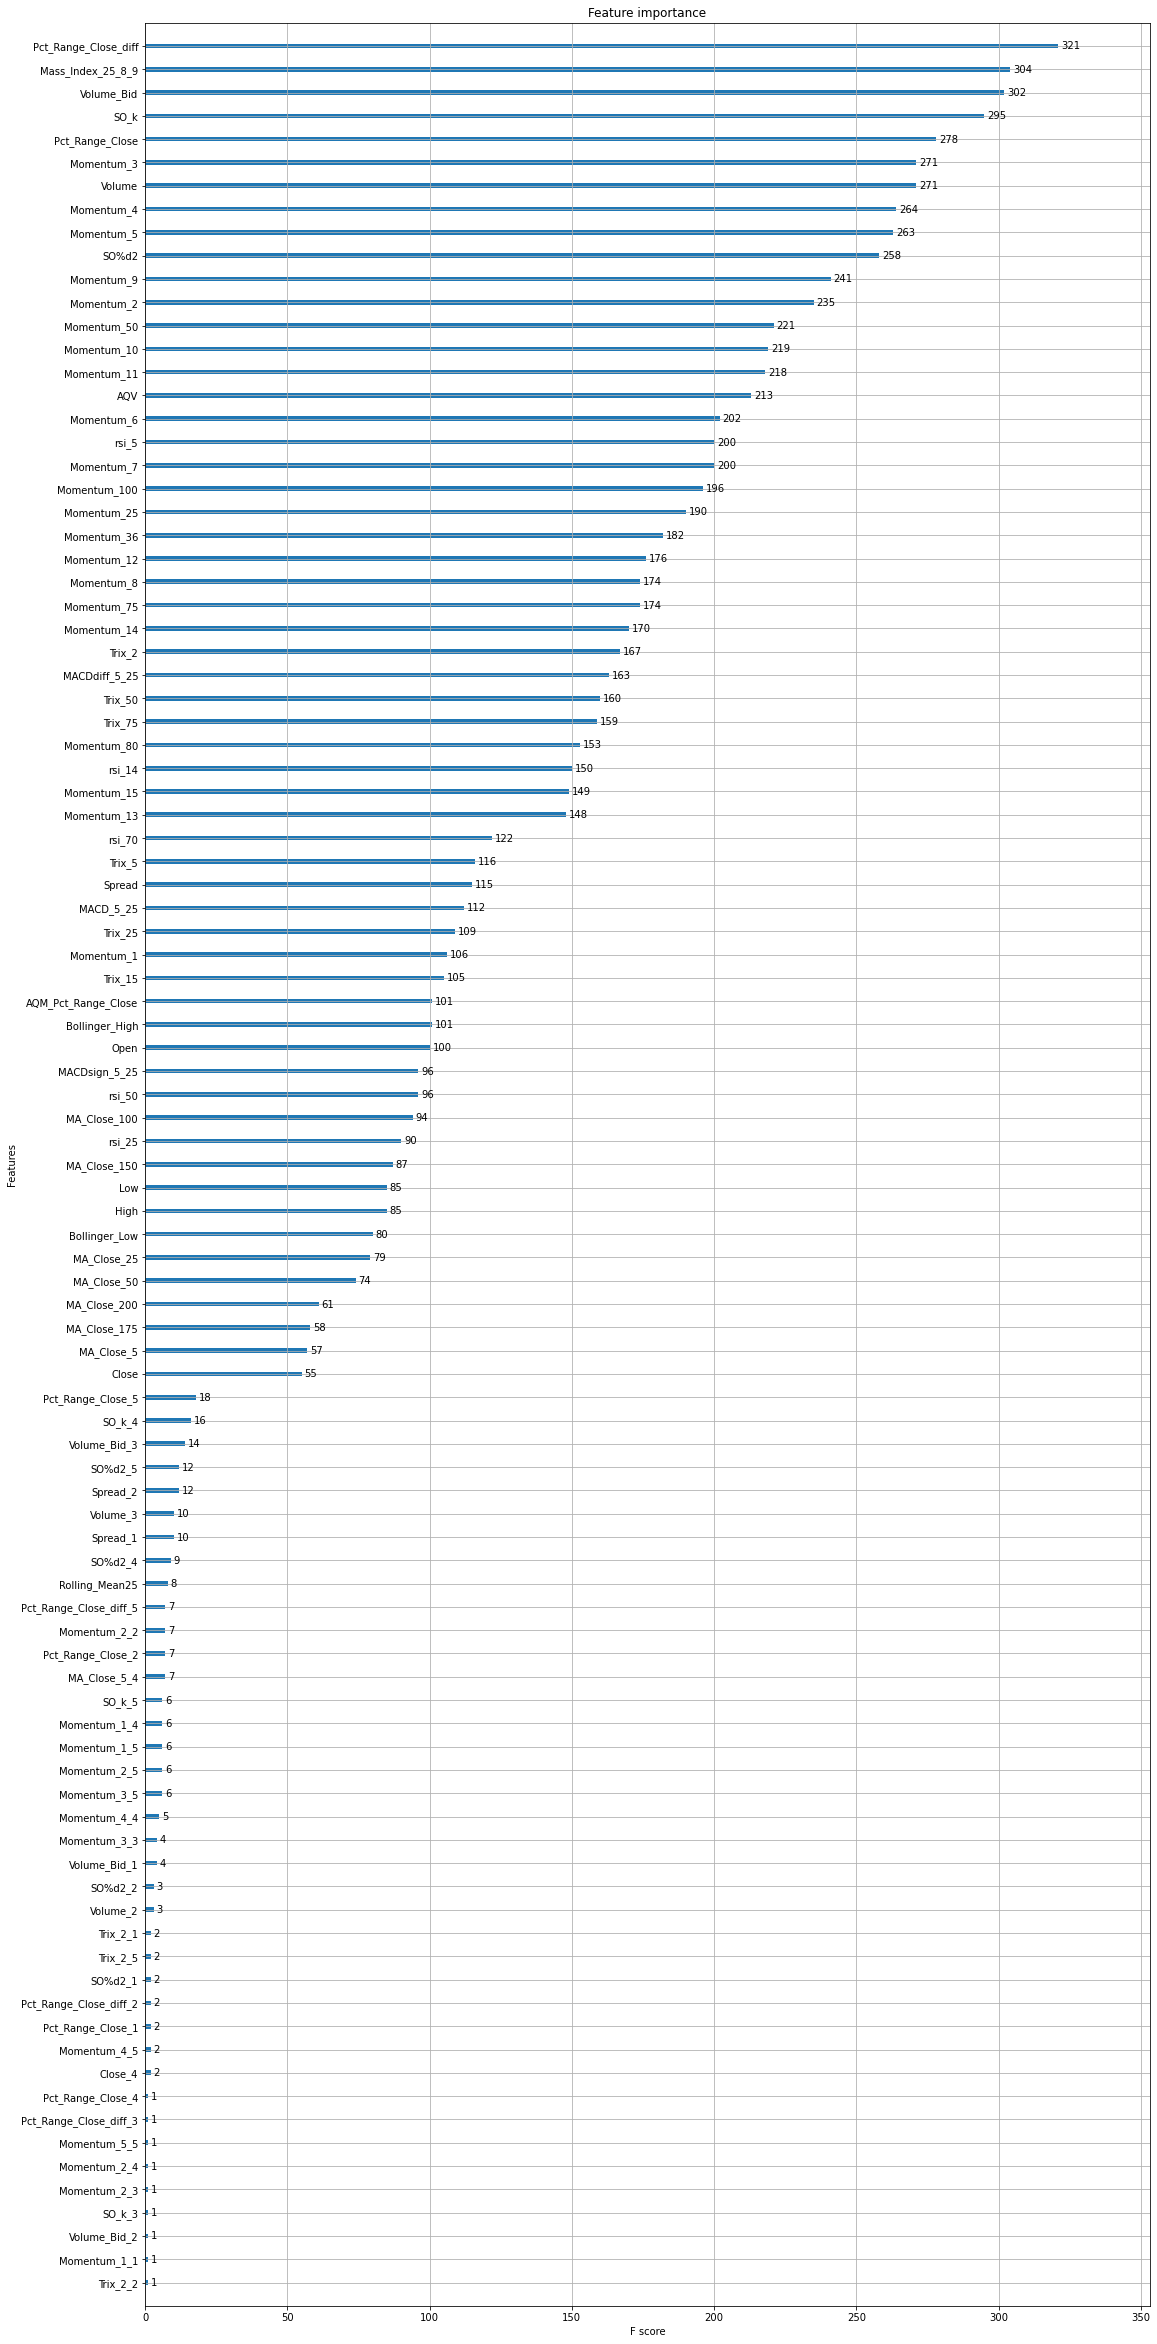

In [504]:
# plot feature importance
ax = plot_importance(bst)
fig = ax.figure
fig.set_size_inches(18, 42)
pyplot.show()

In [505]:
RUN_THRESHOLD = False

if (RUN_THRESHOLD):
    # define custom class to fix bug in xgboost 1.0.2
    class MyXGBClassifier(XGBClassifier):
        @property
        def coef_(self):
            return None

    # split data into X and y
    x,y = data,labels
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42,shuffle=False)

    # fit model on all training data
    model = MyXGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # Fit model using each importance as a threshold
    thresholds = sort(model.feature_importances_)
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier()
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        predictions = selection_model.predict(select_X_test)
        accuracy = accuracy_score(y_test, predictions)
        print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

### Predict Train Dataset

In [506]:
y_train_pred = bst.predict(x_train)

In [507]:
y_train_real = pd.DataFrame({'Real_Class': y_train})
y_train_pred_pd = pd.DataFrame({'Predicted_Class': y_train_pred})
print('y_train_real ',y_train_real.shape)
print('y_train_pred_pd ',y_train_pred_pd.shape)
x_train_real = pd.concat([x_train,y_train_real], axis=1, sort=False)
print('x_train_real ',x_train_real.shape)
x_train = pd.concat([x_train_real,y_train_pred_pd], axis=1, sort=False)
print('x_train ', x_train.shape)

y_train_real  (3083, 1)
y_train_pred_pd  (3083, 1)
x_train_real  (3083, 367)
x_train  (3083, 368)


In [508]:
#Save
x_train.to_csv(train_dataset_results_csv, header=True, index=False)
print(train_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_62F_5137Size_XGBOOST_Class_01_Train.csv


### Predict REAL TEST Dataset

In [509]:
y_rtest_pred = bst.predict(x_rtest)
#x_train,x_test,y_train,y_test

In [510]:
y_rtest_real = pd.DataFrame({'Real_Class': y_rtest})
y_rtest_pred_pd = pd.DataFrame({'Predicted_Class': y_rtest_pred})
print('y_rtest_real ',y_rtest_real.shape)
print('y_rtest_pred_pd ',y_rtest_pred_pd.shape)
x_rtest_real = pd.concat([x_rtest,y_rtest_real], axis=1, sort=False)
print('x_rtest_real ',x_rtest_real.shape)
x_rtest = pd.concat([x_rtest_real,y_rtest_pred_pd], axis=1, sort=False)
print('x_rtest ', x_rtest.shape)

y_rtest_real  (1027, 1)
y_rtest_pred_pd  (1027, 1)
x_rtest_real  (1027, 367)
x_rtest  (1027, 368)


In [511]:
#Save
x_rtest.to_csv(rtest_dataset_results_csv, header=True, index=False)
print(rtest_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_62F_5137Size_XGBOOST_Class_01_RealTest.csv


### Predict Test Dataset

In [512]:
x_test.shape
x_test

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,Trix_2_5,Trix_5_5,Trix_15_5,Trix_25_5,Trix_50_5,Trix_75_5,MACD_5_25_5,MACDsign_5_25_5,MACDdiff_5_25_5,Mass_Index_25_8_9_5
0,1.34722,1.35480,1.34679,1.35178,192986.0000,187872.7813,0.00003,0.003392,0.006611,1.692684e+09,...,-0.000257,-0.001915,0.000318,0.000511,0.000375,0.000245,-0.007501,-0.000750,-0.006751,25.431868
1,1.35175,1.35295,1.32956,1.34090,297183.3125,286899.2813,0.00003,-0.008049,-0.011441,1.692982e+09,...,-0.002124,-0.001971,0.000211,0.000478,0.000374,0.000248,-0.009933,-0.002587,-0.007346,25.719730
2,1.34089,1.34379,1.33179,1.33706,232163.4844,224716.4531,0.00058,-0.002864,0.005185,1.693214e+09,...,-0.002954,-0.002096,0.000096,0.000440,0.000371,0.000249,-0.012159,-0.004501,-0.007658,25.981039
3,1.33577,1.33625,1.33450,1.33466,4142.5801,4146.3799,0.00002,-0.001795,0.001069,1.693218e+09,...,-0.002789,-0.002199,-0.000022,0.000397,0.000368,0.000250,-0.013832,-0.006367,-0.007465,26.029182
4,1.33468,1.34167,1.33468,1.34077,153372.9375,150607.0938,0.00002,0.004578,0.006373,1.693371e+09,...,-0.000535,-0.002021,-0.000129,0.000354,0.000363,0.000251,-0.012941,-0.007682,-0.005259,26.161186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,1.06292,1.06382,1.06178,1.06191,5538.0098,5510.5098,0.00004,-0.002217,-0.000810,1.925178e+09,...,-0.001990,-0.001087,0.000478,0.000242,-0.000348,-0.000364,-0.002328,0.002461,-0.004789,23.832097
1023,1.06189,1.06586,1.05922,1.05991,205467.4375,198618.6719,0.00004,-0.001883,0.000334,1.925383e+09,...,-0.001971,-0.001287,0.000401,0.000238,-0.000337,-0.000361,-0.003709,0.001227,-0.004936,23.810700
1024,1.05990,1.06335,1.05610,1.05785,220620.4375,220040.6406,0.00003,-0.001944,-0.000060,1.925604e+09,...,-0.001956,-0.001446,0.000317,0.000229,-0.000327,-0.000357,-0.004992,-0.000017,-0.004975,23.872828
1025,1.05785,1.06094,1.05216,1.06034,237565.8438,239541.8438,0.00004,0.002354,0.004297,1.925842e+09,...,-0.000679,-0.001412,0.000236,0.000217,-0.000318,-0.000354,-0.005015,-0.001017,-0.003999,23.907942


In [513]:
y_test_pred = bst.predict(x_test)
#x_train,x_test,y_train,y_test

In [514]:
y_test_pred.shape

(1027,)

In [515]:
y_test_pred

array([0., 0., 0., ..., 1., 1., 0.])

In [516]:
y_test_real = pd.DataFrame({'Real_Class': y_test})
y_test_pred_pd = pd.DataFrame({'Predicted_Class': y_test_pred})
print('y_test_real ',y_test_real.shape)
print('y_test_pred_pd ',y_test_pred_pd.shape)
x_test_real = pd.concat([x_test,y_test_real], axis=1, sort=False)
print('x_test_real ',x_test_real.shape)
x_test = pd.concat([x_test_real,y_test_pred_pd], axis=1, sort=False)
print('x_test ', x_test.shape)

y_test_real  (1027, 1)
y_test_pred_pd  (1027, 1)
x_test_real  (1027, 367)
x_test  (1027, 368)


In [517]:

print(x_test['Predicted_Class'].isnull().sum())
#DATASET_FULL.fillna(method='backfill', inplace=True)

0


In [518]:
#Save
x_test.to_csv(test_dataset_results_csv, header=True, index=False)
print(test_dataset_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/XGBoost/3C_1D_62F_5137Size_XGBOOST_Class_01_Test.csv
